In [29]:
import os
import pandas as pd
wkdir="/home/adrianhurtado/testing/madness-test-suite/post_florian"
os.chdir(wkdir)
from madnessReader import MadnessReader
from madnessReader import ExcitedData
from madnessReader import FrequencyData
from daltonRunner import DaltonRunner
import matplotlib.pyplot as plt
dalton_reader = DaltonRunner()

In [30]:
basis_list=['aug-cc-pVDZ','aug-cc-pVTZ','aug-cc-pVQZ','aug-cc-pV5Z','aug-cc-pV6Z']
d_basis_list=['d-aug-cc-pVDZ','d-aug-cc-pVTZ','d-aug-cc-pVQZ','d-aug-cc-pV5Z','d-aug-cc-pV6Z']

In [31]:
def create_polar_table(mol,xc,basis_list,xx):
    
    ground_dalton, response_dalton = dalton_reader.get_frequency_result(mol, 'hf', 'dipole', basis_list[0])
    freq=response_dalton['frequencies']
    g_data={}
    xx_data=[]
    for i in range(len(freq)):
        xx_data.append({})
    for basis in basis_list:
        ground_dalton, response_dalton = dalton_reader.get_frequency_result(mol, 'hf', 'dipole', basis)
        for i in range(len(freq)):
            xx_data[i][basis]=response_dalton[xx][i]
        g_data[basis]=ground_dalton['totalEnergy']
    g_df=pd.Series(g_data)
    g_df.name='Total HF Energy'
    names=[]
    for f in freq:
        raw_f = r'{}'.format(str(f)) 
        #names.append(r'$$\alpha_{xx}('+raw_f+r')$$')
        names.append('a('+'{:.3f}'.format(f)+')')
    r_dfs=[]
    for i in range(len(freq)):
        r_dfs.append(pd.Series(xx_data[i]))
        r_dfs[i].name=names[i]
    dalton_df=pd.concat([g_df]+r_dfs,axis=1)

    moldata=FrequencyData(mol,'hf','dipole')
    moldata.polar_df[xx]
    mad_data_e={}
    mad_data_r={}
    mad_data_e['Total HF Energy']=moldata.ground_e['e_tot']

    for i in range(len(names)):
        mad_data_r[names[i]]=moldata.polar_df[xx][i]
    
    mad_data_e=pd.Series(mad_data_e)
    mad_data_r=pd.Series(mad_data_r)
    
    mad_data=pd.concat([mad_data_e,mad_data_r],axis=0)
    mad_data.name='MRA'
    return dalton_df.append(mad_data)
    
    return dalton_df

def create_data(mol,basis_list):
    
    res_dict={'xx':'density_residualX','yy':'density_residualY','zz':'density_residualZ'}
    
    
    moldata=FrequencyData(mol,'hf','dipole')
    xx=['xx','yy','zz']
    data=[]
    for x in xx:
        data.append(create_polar_table(mol,'hf',basis_list,x))
    average=(data[0]+data[1]+data[2])/3
    
    diff_data=average-average.loc['MRA']
    diff_data=diff_data.drop(index='MRA')
    
    polar_diff=diff_data.drop('Total HF Energy',axis=1)
    
    residuals=moldata.final_density_residuals()
    
    cleanX=residuals['density_residualX'].reset_index().drop('index',axis=1)
    cleanY=residuals['density_residualY'].reset_index().drop('index',axis=1)
    cleanZ=residuals['density_residualZ'].reset_index().drop('index',axis=1)
    
    cleanX.rename(columns={'density_residualX':'MRA density residual'},inplace=True)
    cleanY.rename(columns={'density_residualY':'MRA density residual'},inplace=True)
    cleanZ.rename(columns={'density_residualZ':'MRA density residual'},inplace=True)
    clean=(cleanX+cleanY+cleanZ)/3
    clean.index=polar_diff.T.index
    
    average=average.append(clean.T)
    average.name='Average Polarizability'
    
    
    energy_diff=diff_data['Total HF Energy']
    return average,diff_data,energy_diff,polar_diff



def create_polar_diff_plot(mol,basis_list):
    
    
    title=mol
    yl=r' $\Delta\alpha_{avg}$'+r' (MRA - BASIS)'
    
    
    data,diff_data,energy_diff,polar_diff=create_data(mol,basis_list)
    polar_diff.iloc[:,:].plot(marker='o', linestyle='solid')
    plt.axhline(linewidth=2,ls='--',color='k',label="MRA Reference")
    plt.xlabel
    plt.legend(fontsize=12)
    plt.xticks(fontsize=14,rotation = 20)
    plt.title(title,fontsize=20)
    plt.ylabel(yl, fontsize=14)
    save=mol+'-'+basis_list[0]
    if not os.path.exists("figures"):
        os.mkdir("figures")
    if not os.path.exists("tables"):
        os.mkdir("tables")
    save='figures/'+save+'.svg'
    plt.savefig(save)
    
    latex_save=mol+'-'+basis_list[0]
    latex_save='tables/'+latex_save+'.tex'
    data=data.round(decimals=3)
    data.to_latex(latex_save,na_rep=' ')
    
    
    return data


,Total HF Energy,a(0.000),a(0.020),a(0.040),a(0.079),a(0.159)
aug-cc-pVDZ,-76.041,8.141,8.150,8.175,8.281,8.763
aug-cc-pVTZ,-76.061,8.428,8.437,8.464,8.575,9.079
aug-cc-pVQZ,-76.066,8.508,8.518,8.545,8.659,9.176
aug-cc-pV5Z,-76.067,8.528,8.538,8.566,8.681,9.203
aug-cc-pV6Z,-76.067,8.536,8.545,8.573,8.689,9.214
MRA,-76.067,8.543,8.552,8.580,8.696,9.225
MRA density residual,NaN,0.000,0.000,0.000,0.000,0.000


,Total HF Energy,a(0.000),a(0.020),a(0.040),a(0.079),a(0.159)
d-aug-cc-pVDZ,-76.042,8.522,8.531,8.559,8.676,9.205
d-aug-cc-pVTZ,-76.061,8.545,8.554,8.582,8.699,9.229
d-aug-cc-pVQZ,-76.066,8.544,8.553,8.582,8.698,9.227
d-aug-cc-pV5Z,-76.067,8.542,8.551,8.579,8.696,9.225
d-aug-cc-pV6Z,-76.067,8.542,8.551,8.579,8.696,9.225
MRA,-76.067,8.543,8.552,8.580,8.696,9.225
MRA density residual,NaN,0.000,0.000,0.000,0.000,0.000


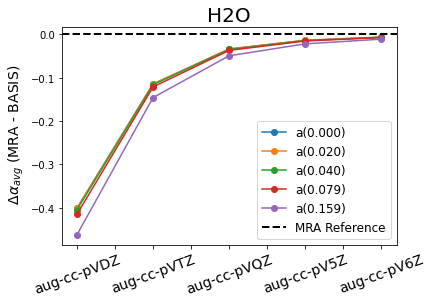

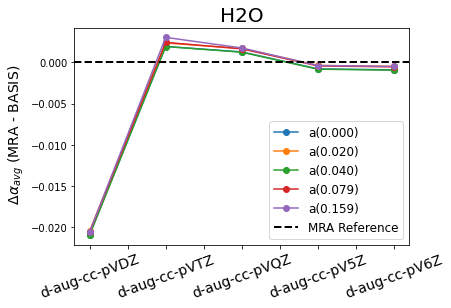

In [32]:

d1=create_polar_diff_plot('H2O',basis_list)
d2=create_polar_diff_plot('H2O',d_basis_list)
display(d1)
display(d2)

,Total HF Energy,a(0.000),a(0.011),a(0.022),a(0.044),a(0.089)
aug-cc-pVDZ,-14.572,44.914,45.080,45.587,47.738,58.900
aug-cc-pVTZ,-14.573,45.440,45.615,46.148,48.412,60.287
aug-cc-pVQZ,-14.573,45.599,45.776,46.316,48.612,60.700
MRA,-14.573,45.625,45.803,46.345,48.662,60.824
MRA density residual,NaN,0.000,0.000,0.000,0.000,0.000


,Total HF Energy,a(0.000),a(0.011),a(0.022),a(0.044),a(0.089)
d-aug-cc-pVDZ,-14.572,44.993,45.160,45.670,47.830,59.050
d-aug-cc-pVTZ,-14.573,45.447,45.622,46.155,48.421,60.310
d-aug-cc-pVQZ,-14.573,45.599,45.776,46.317,48.614,60.707
MRA,-14.573,45.625,45.803,46.345,48.662,60.824
MRA density residual,NaN,0.000,0.000,0.000,0.000,0.000


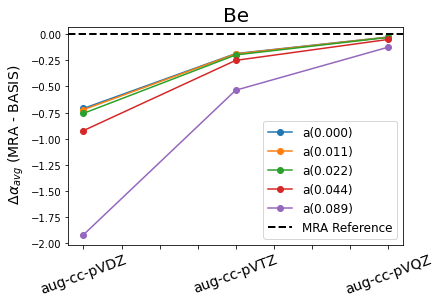

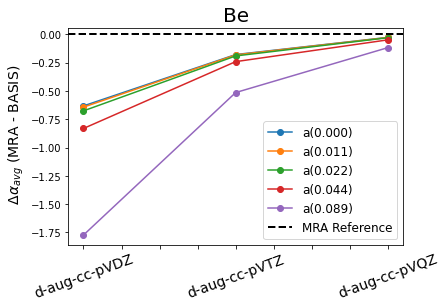

In [33]:

d1=create_polar_diff_plot('Be',basis_list[0:-2])
d2=create_polar_diff_plot('Be',d_basis_list[0:-2])
display(d1)
display(d2)

In [34]:

def create_polar_table(mol,xc,basis_list,xx):
    ground_dalton, response_dalton = dalton_reader.get_frequency_result(mol, 'hf', 'dipole', basis_list[0])

/home/adrianhurtado/testing/madness-test-suite/post_florian
basis                     d-aug-cc-pVQZ
totalEnergy                   -14.57297
nuclearRepulsionEnergy              0.0
electronEnergy                -14.57297
gcpuTime                          0.518
gwallTime                         0.523
rcpuTime                           0.28
rwallTime                          0.28
numberOfElectrons                     4
wall_time                    9724.45259
e_coulomb                      7.155849
e_kinetic                      14.57248
e_local                             0.0
e_nrep                              0.0
e_tot                        -14.573022
dtype: object
   Sym  Mode      freq  mad-omega  delta-omega  d-residual  bshx-residual  \
0    5     1  0.176939   0.178632    -0.001693    0.002234       0.014018   
1    3     1  0.176939   0.178635    -0.001696    0.002189       0.014504   
2    2     1  0.176939   0.178738    -0.001799    0.002056       0.018085   
3    1     1  0.22

/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omega_df['mad-omega'] = self.omega
/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omega_df['delta-omega'] = omega_df['freq'] - omega_df['mad-omega']
/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:511: SettingWithCopyWarning: 
A value is trying to be set o

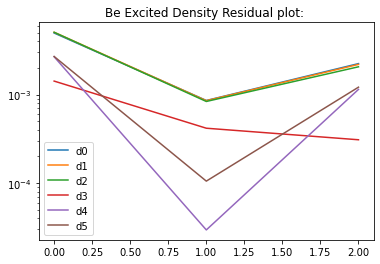

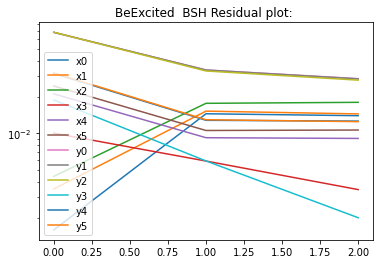

In [35]:
def excited_results(mol):
    f_data=ExcitedData(mol,'hf')
    f_data.plot_density_residuals()
    f_data.plot_bsh_residuals()
    ground,omega_df=f_data.compare_dalton('d-aug-cc-pVQZ')
    print(ground)
    print(omega_df)
excited_results('Be')

In [38]:
be_data=ExcitedData('Be','hf')

/home/adrianhurtado/testing/madness-test-suite/post_florian


<AxesSubplot:>

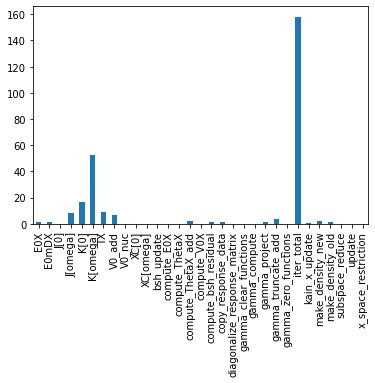

In [39]:
be_data.wall_time.sum().plot.bar()


<AxesSubplot:>

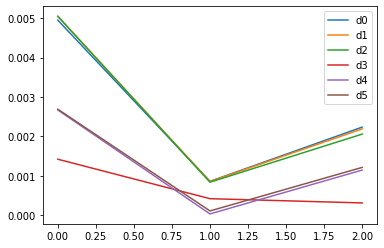

In [40]:
be_data.d_residuals.plot()


In [41]:
be_data.omega

0    0.178632
1    0.178635
2    0.178738
3    0.224858
4    0.247512
5    0.247531
Name: 2, dtype: float64

In [42]:
be_data.compare_dalton('d-aug-cc-pVQZ')

/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omega_df['mad-omega'] = self.omega
/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omega_df['delta-omega'] = omega_df['freq'] - omega_df['mad-omega']
/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:511: SettingWithCopyWarning: 
A value is trying to be set o

(basis                     d-aug-cc-pVQZ
 totalEnergy                   -14.57297
 nuclearRepulsionEnergy              0.0
 electronEnergy                -14.57297
 gcpuTime                          0.518
 gwallTime                         0.523
 rcpuTime                           0.28
 rwallTime                          0.28
 numberOfElectrons                     4
 wall_time                    9724.45259
 e_coulomb                      7.155849
 e_kinetic                      14.57248
 e_local                             0.0
 e_nrep                              0.0
 e_tot                        -14.573022
 dtype: object,
    Sym  Mode      freq  mad-omega  delta-omega  d-residual  bshx-residual  \
 0    5     1  0.176939   0.178632    -0.001693    0.002234       0.014018   
 1    3     1  0.176939   0.178635    -0.001696    0.002189       0.014504   
 2    2     1  0.176939   0.178738    -0.001799    0.002056       0.018085   
 3    1     1  0.224906   0.224858     0.000048    0.0003

In [44]:


h2=ExcitedData('H2','hf')
h2.compare_dalton('d-aug-cc-pVQZ')

/home/adrianhurtado/testing/madness-test-suite/post_florian
did not find output file
Try and run molecule  H2
b'\n   ******************************************* \n   **** OUTPUT FROM DALTON SHELL SCRIPT\n   ******************************************* \n\n   DALTON release Dalton2020.1 (2022)\n\n   Invocation: /home/adrianhurtado/projects/dalton/build/dalton excited.dal H2-d-aug-cc-pVQZ.mol\n\n   Tue Jun 14 05:45:02 PM EDT 2022\n\n   Calculation: excited_H2-d-aug-cc-pVQZ  (input files: excited.dal and H2-d-aug-cc-pVQZ.mol)\n   PID        : 125471\n   Input dir  : /home/adrianhurtado/testing/madness-test-suite/dalton/dalton/hf/H2/excited-state\n   Scratch dir: /media/adrianhurtado/NewScratch/DALTON_scratch_adrianhurtado/excited_H2-d-aug-cc-pVQZ_125471\n\n\n DALTON: default work memory size used.            64000000\n\n Work memory size (LMWORK+2):    64000002 =  488.28 megabytes; node   0\n\n   0: Directories for basis set searches:\n     /home/adrianhurtado/testing/madness-test-suite/da

/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omega_df['mad-omega'] = self.omega
/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omega_df['delta-omega'] = omega_df['freq'] - omega_df['mad-omega']
/home/adrianhurtado/testing/madness-test-suite/madness-test-suite/madnessReader.py:511: SettingWithCopyWarning: 
A value is trying to be set o

(basis                     d-aug-cc-pVQZ
 totalEnergy                   -1.133471
 nuclearRepulsionEnergy         0.713754
 electronEnergy                -1.847225
 gcpuTime                          0.378
 gwallTime                         0.378
 rcpuTime                           0.26
 rwallTime                          0.26
 numberOfElectrons                     2
 wall_time                   2441.760483
 e_coulomb                      1.316798
 e_kinetic                      1.125487
 e_local                             0.0
 e_nrep                         0.713754
 e_tot                         -1.133622
 dtype: object,
    Sym  Mode      freq  mad-omega  delta-omega  d-residual  bshx-residual  \
 0    5     1  0.465376   0.465369     0.000007         0.0       0.000318   
 1    1     1  0.477069   0.476992     0.000077         0.0       0.000459   
 2    2     1  0.480889   0.480661     0.000228         0.0       0.000552   
 3    3     1  0.480889   0.480661     0.000228         0

In [45]:

ch4=ExcitedData('CH4','hf')




/home/adrianhurtado/testing/madness-test-suite/post_florian


In [ ]:
ch4.compare_dalton('d-aug-cc-pV5Z')

did not find output file
Try and run molecule  CH4



 NOTE:    1 warnings have been issued.
 Check output, result, and error files for "WARNING".
